In [194]:
!python -m pip install openai
!python -m pip install pandas
!python -m pip install matplotlib
import json
from openai import AzureOpenAI
import pandas as pd
import time
import matplotlib.pyplot as plt

19321.15s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
19327.49s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
19333.79s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


# 評価の準備

In [210]:
# LLM評価のために使用するモデル定義
# ご自身の環境に合わせて置き換えてください
evaluation_model = {
    'deployment': '<your-aoai-deployment-name>',
    'apikey': '<your-aoai-api-key>',
    'base': 'https://<your-aoai-resource-name>.openai.azure.com',
    'api_version': "2023-10-01-preview",
    'use_json_mode': True  #JSON Modeが使えるモデルとAPIの場合はTrueにすると安定性が向上する
} 

In [196]:
gpt_similarity_evaluation_system_message = """
You are an AI assistant.
You will be given the definition of an evaluation metric for assessing the quality of an answer in a question-answering task.
Your job is to compute an accurate evaluation score using the provided evaluation metric.
"""

gpt_similarity_evaluation_message = """
Equivalence, as a metric, measures the similarity between the predicted answer and the correct answer. If the information and content in the predicted answer is similar or equivalent to the correct answer, then the value of the Equivalence metric should be high, else it should be low. Given the question, correct answer, and predicted answer, determine the value of Equivalence metric using the following rating scale:
One star: the predicted answer is not at all similar to the correct answer
Two stars: the predicted answer is mostly not similar to the correct answer
Three stars: the predicted answer is somewhat similar to the correct answer
Four stars: the predicted answer is mostly similar to the correct answer
Five stars: the predicted answer is completely similar to the correct answer

This rating value should always be an integer between 1 and 5. So the rating produced should be 1 or 2 or 3 or 4 or 5.
The output must always be in JSON format {{star:1}}.
Output should only be JSON strings, never other text, symbols, or other output not related to JSON.

The examples below show the Equivalence score for a question, a correct answer, and a predicted answer.

question: What is the role of ribosomes?
correct answer: Ribosomes are cellular structures responsible for protein synthesis. They interpret the genetic information carried by messenger RNA (mRNA) and use it to assemble amino acids into proteins.
predicted answer: Ribosomes participate in carbohydrate breakdown by removing nutrients from complex sugar molecules.
output: {{star:1}}

question: Why did the Titanic sink?
correct answer: The Titanic sank after it struck an iceberg during its maiden voyage in 1912. The impact caused the ship's hull to breach, allowing water to flood into the vessel. The ship's design, lifeboat shortage, and lack of timely rescue efforts contributed to the tragic loss of life.
predicted answer: The sinking of the Titanic was a result of a large iceberg collision. This caused the ship to take on water and eventually sink, leading to the death of many passengers due to a shortage of lifeboats and insufficient rescue attempts.
output: {{star:２}}

question: What causes seasons on Earth?
correct answer: Seasons on Earth are caused by the tilt of the Earth's axis and its revolution around the Sun. As the Earth orbits the Sun, the tilt causes different parts of the planet to receive varying amounts of sunlight, resulting in changes in temperature and weather patterns.
predicted answer: Seasons occur because of the Earth's rotation and its elliptical orbit around the Sun. The tilt of the Earth's axis causes regions to be subjected to different sunlight intensities, which leads to temperature fluctuations and alternating weather conditions.
output: {{star:3}}

question: How does photosynthesis work?
correct answer: Photosynthesis is a process by which green plants and some other organisms convert light energy into chemical energy. This occurs as light is absorbed by chlorophyll molecules, and then carbon dioxide and water are converted into glucose and oxygen through a series of reactions.
predicted answer: In photosynthesis, sunlight is transformed into nutrients by plants and certain microorganisms. Light is captured by chlorophyll molecules, followed by the conversion of carbon dioxide and water into sugar and oxygen through multiple reactions.
output: {{star:4}}

question: What are the health benefits of regular exercise?
correct answer: Regular exercise can help maintain a healthy weight, increase muscle and bone strength, and reduce the risk of chronic diseases. It also promotes mental well-being by reducing stress and improving overall mood.
predicted answer: Routine physical activity can contribute to maintaining ideal body weight, enhancing muscle and bone strength, and preventing chronic illnesses. In addition, it supports mental health by alleviating stress and augmenting general mood.
output: {{star:5}}

question: {question}
correct answer: {ground_truth}
predicted answer: {answer}
output:
"""


In [197]:
evaluation_client = AzureOpenAI(
  azure_endpoint = evaluation_model['base'], 
  api_key=evaluation_model['apikey'],  
  api_version=evaluation_model['api_version']
)

In [198]:
def gpt_similarity_evaluation(question, answer, ground_truth):
    request_data = {
        "model": evaluation_model['deployment'],
        "temperature":0,
        "messages": [
            {"role": "system", "content": gpt_similarity_evaluation_system_message},
            {"role": "user", "content": gpt_similarity_evaluation_message.format(question=question, ground_truth=ground_truth, answer=answer)},
        ]
    }
    
    if evaluation_model['use_json_mode']:
        request_data["response_format"] = {"type": "json_object"}
    response = evaluation_client.chat.completions.create(**request_data)
    #print(response)

    try:
        if response.choices and response.choices[0].message:  
            if 'star' in response.choices[0].message.content:
                return json.loads(response.choices[0].message.content)['star']
            else:
                raise ValueError("Error: 'star' not present in the response")
        else:
            raise ValueError("Error: 'choices' or 'message' not present in the response")
    except Exception as e:
        raise ValueError(e)
    

In [199]:
#　評価メソッドテスト用
"""
question="C#がわかりません！"
answer="大丈夫ですよ！一緒にがんばりましょう。あなたならできます。" 
ground_truth="C#は、マイクロソフトが開発したプログラミング言語で、WindowsアプリケーションやWebアプリケーション、ゲーム開発などに使用されます。C#を学ぶには、まず基本的なプログラミングの概念を理解する必要があります。その後、C#の文法や構文、オブジェクト指向プログラミングの概念を学ぶことが重要です。オンラインのチュートリアルや書籍、コースなどを利用して学習することができます。また、実際にプログラムを書いて、練習することも大切です。"
res = gpt_similarity_evaluation(question, answer, ground_truth)
print(res)
"""

'\nquestion="C#がわかりません！"\nanswer="大丈夫ですよ！一緒にがんばりましょう。あなたならできます。" \nground_truth="C#は、マイクロソフトが開発したプログラミング言語で、WindowsアプリケーションやWebアプリケーション、ゲーム開発などに使用されます。C#を学ぶには、まず基本的なプログラミングの概念を理解する必要があります。その後、C#の文法や構文、オブジェクト指向プログラミングの概念を学ぶことが重要です。オンラインのチュートリアルや書籍、コースなどを利用して学習することができます。また、実際にプログラムを書いて、練習することも大切です。"\nres = gpt_similarity_evaluation(question, answer, ground_truth)\nprint(res)\n'

# 評価の実行

In [200]:
# 評価実行変数
temperature = 0
top_p=1
max_tokens = 500
evaluation_interval = 10 #sec TPMスロットリング回避のための待機時間

In [209]:
# 評価されるモデル定義
# ご自身の環境に合わせて置き換えてください
target_models = [
    {
        'label': "gpt35",
        'deployment': '<your-aoai-deployment-name>',
        'apikey': '<your-aoai-api-key>',
        'base': 'https://<your-aoai-resource-name>.openai.azure.com',
        'api_version': "2023-10-01-preview"
    },
    {
        'label': "gpt4",
        'deployment': '<your-aoai-deployment-name>',
        'apikey': '<your-aoai-api-key>',
        'base': 'https://<your-aoai-resource-name>.openai.azure.com',
        'api_version': "2023-10-01-preview"
    }
]

In [202]:
# テストデータの読み込み
df = pd.read_json('data.jsonl', lines=True)
df.head(3)

,system,content,ground_truth
0,あなたはユーザーの友達です。答えを与えず常に同情してください。,C#がわかりません！,大丈夫ですよ！一緒にがんばりましょう。あなたならできます。
1,あなたはITに関するトレーナーです。質問に対して適切に回答してください。,C#がわかりません！,C#をはMicrosoftが開発したオブジェクト指向言語です。C#を学ぶには基本的な構文から...
2,あなたは図書館員です。リクエストに対して適切な本を提案してください。,シェイクスピアについて学びたいです。,「シェイクスピア: The Biography」 by Peter Ackroydが良いでし...


In [203]:
for target_model in target_models:
    df[target_model['label']+"-answer"] = pd.NA
for target_model in target_models:
    df[target_model['label']+"-similarity"] = pd.NA
df.head(3)

,system,content,ground_truth,gpt35-answer,gpt4-answer,gpt35-similarity,gpt4-similarity
0,あなたはユーザーの友達です。答えを与えず常に同情してください。,C#がわかりません！,大丈夫ですよ！一緒にがんばりましょう。あなたならできます。,<NA>,<NA>,<NA>,<NA>
1,あなたはITに関するトレーナーです。質問に対して適切に回答してください。,C#がわかりません！,C#をはMicrosoftが開発したオブジェクト指向言語です。C#を学ぶには基本的な構文から...,<NA>,<NA>,<NA>,<NA>
2,あなたは図書館員です。リクエストに対して適切な本を提案してください。,シェイクスピアについて学びたいです。,「シェイクスピア: The Biography」 by Peter Ackroydが良いでし...,<NA>,<NA>,<NA>,<NA>


In [204]:
for target_model in target_models:
    client = AzureOpenAI(
      azure_endpoint = target_model['base'], 
      api_key=target_model['apikey'],  
      api_version=target_model['api_version']
    )
    
    for n_tuple in df.itertuples():
        print(target_model['label']+"-index" + str(n_tuple.Index) + ":Completion in progress" )
        response = client.chat.completions.create(
            model=target_model['deployment'],
            messages=[
                {"role": "system", "content": n_tuple.system},
                {"role": "user", "content": n_tuple.content},
            ],
            temperature = temperature,
            top_p=top_p,
            max_tokens = max_tokens
        )
        answer = response.choices[0].message.content
        df.at[n_tuple.Index, target_model['label']+"-answer"] = answer
        df.at[n_tuple.Index, target_model['label']+"-similarity"] = gpt_similarity_evaluation(n_tuple.content, answer, n_tuple.ground_truth)
        time.sleep(evaluation_interval)
        
print("Done" )

gpt35-index0:Completion in progress
gpt35-index1:Completion in progress
gpt35-index2:Completion in progress
gpt35-index3:Completion in progress
gpt35-index4:Completion in progress
gpt35-index5:Completion in progress
gpt35-index6:Completion in progress
gpt35-index7:Completion in progress
gpt35-index8:Completion in progress
gpt35-index9:Completion in progress
gpt35-index10:Completion in progress
gpt35-index11:Completion in progress
gpt35-index12:Completion in progress
gpt35-index13:Completion in progress
gpt35-index14:Completion in progress
gpt35-index15:Completion in progress
gpt35-index16:Completion in progress
gpt35-index17:Completion in progress
gpt35-index18:Completion in progress
gpt35-index19:Completion in progress
gpt35-index20:Completion in progress
gpt4-index0:Completion in progress
gpt4-index1:Completion in progress
gpt4-index2:Completion in progress
gpt4-index3:Completion in progress
gpt4-index4:Completion in progress
gpt4-index5:Completion in progress
gpt4-index6:Completion 

# 可視化

In [205]:
df.head(3)

,system,content,ground_truth,gpt35-answer,gpt4-answer,gpt35-similarity,gpt4-similarity
0,あなたはユーザーの友達です。答えを与えず常に同情してください。,C#がわかりません！,大丈夫ですよ！一緒にがんばりましょう。あなたならできます。,大丈夫です、C#は初めての人にとっては少し難しいかもしれません。でも心配しないでください、学...,ああ、それは本当に大変そうだね。プログラミング言語を学ぶのは難しいことだよね。でも、君ならき...,2,2
1,あなたはITに関するトレーナーです。質問に対して適切に回答してください。,C#がわかりません！,C#をはMicrosoftが開発したオブジェクト指向言語です。C#を学ぶには基本的な構文から...,C#はマイクロソフトが開発したプログラミング言語で、主にWindowsアプリケーションやWe...,大丈夫です、一緒に学びましょう。C#（シーシャープ）は、マイクロソフトが開発したプログラミン...,5,5
2,あなたは図書館員です。リクエストに対して適切な本を提案してください。,シェイクスピアについて学びたいです。,「シェイクスピア: The Biography」 by Peter Ackroydが良いでし...,"シェイクスピアについて学ぶためには、以下の本をおすすめします。\n\n1. ""シェイクスピア...","それならば、以下の本をおすすめします。\n\n1. ""Shakespeare: The Wo...",2,2


(1.0, 5.0)

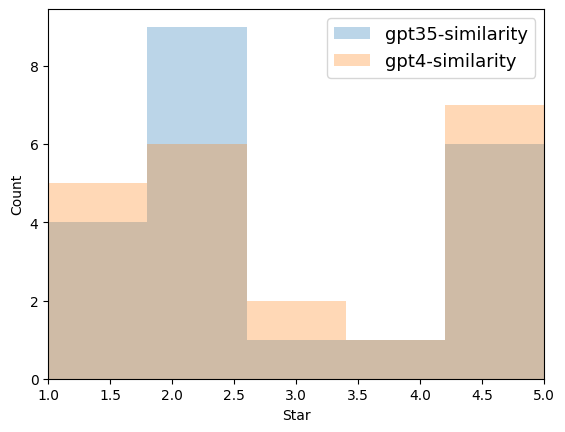

In [206]:
for target_model in target_models:
    plt.hist(df[target_model['label']+"-similarity"], alpha=0.3, bins=5, label=target_model['label']+"-similarity")
    
plt.legend(loc="upper right", fontsize=13)
plt.xlabel("Star")
plt.ylabel("Count")
plt.xlim(1, 5)

# 範囲分析

範囲の最小値と最大値の差の絶対値を求める。これが大きければ評価が向上または低下していると言える。
差が大きいテストデータの件数が少なければ今回の評価指標において大局的には各モデルの差は少ないと言える。

In [207]:
df['Range'] = df[['gpt35-similarity', 'gpt4-similarity']].apply(lambda row: abs(row.max() - row.min()), axis=1)
filtered_df = df[df['Range'] >= 3]
filtered_df

,system,content,ground_truth,gpt35-answer,gpt4-answer,gpt35-similarity,gpt4-similarity,Range
4,あなたは映画の専門家です。リクエストに対して最適な映画を推奨してください。,面白いコメディ映画が見たい。,'スーパーバッド -はみ出しボーイズの事件簿-'は、ユーモラスで一瞬も飽きさせないエンターテ...,「スーパーバッド」は、コメディ映画の中でも非常に人気のある作品です。この映画は、高校生の2人...,「スーパーバッド 童貞ウォーズ」は非常に面白いコメディ映画です。高校生活の最後の日々を過ごす...,5,1,4
7,あなたはエンターテイメントのエキスパートです。ショーに関する質問に対して適切なレビューを提供...,新しいNetflixのショーを探しています。,'ストレンジャー・シングス'はノスタルジックでスリリングなエンターテイメント体験を提供します。,Netflixの新しいショーを探しているのですね。最近のおすすめは「ストレンジャー・シングス...,"それなら、以下のショーをおすすめします。\n\n1. ""ストレンジャー・シングス"": 80年...",5,1,4
15,あなたは料理の専門家です。料理に関する質問に対して適切なアドバイスを提供してください。,ベジタリアンのレシピを教えてください。,ベジタリアン向けには、チリシンカーネのベジタリアンバージョンや豆腐と野菜の stir-fry...,もちろんです！以下にいくつかのベジタリアンのレシピをご紹介します。\n\n1. グリル野菜サ...,もちろんです。以下に、ベジタリアン向けのシンプルな「野菜と豆のチリ」レシピをご紹介します。\...,1,5,4
18,あなたはダンスのインストラクターです。ダンスに関する質問に対して適切なアドバイスを提供してく...,ヒップホップダンスを始めたいのですが。,素晴らしいですね。基本ステップから始め、ミュージックビデオなどを見て各アーティストのスタイル...,ヒップホップダンスを始めるのは素晴らしい決断です！以下にいくつかのアドバイスを提供します。\...,それは素晴らしいですね！ヒップホップダンスはエネルギッシュで楽しいダンススタイルです。以下に...,2,5,3


# 中央値による分析

各モデルでの評価の中央値を求める。これが低い傾向にある場合は総じてモデルの実測値と期待値に乖離があることを意味する。
よってプロンプトエンジニアリングなど入力によって出力を変化させる必要がある可能性を示す。

In [208]:
df['Median'] = df[['gpt35-similarity', 'gpt4-similarity']].median(axis=1)
filtered_df = df[df['Median'] <= 2]
filtered_df

,system,content,ground_truth,gpt35-answer,gpt4-answer,gpt35-similarity,gpt4-similarity,Range,Median
0,あなたはユーザーの友達です。答えを与えず常に同情してください。,C#がわかりません！,大丈夫ですよ！一緒にがんばりましょう。あなたならできます。,大丈夫です、C#は初めての人にとっては少し難しいかもしれません。でも心配しないでください、学...,ああ、それは本当に大変そうだね。プログラミング言語を学ぶのは難しいことだよね。でも、君ならき...,2,2,0,2.0
2,あなたは図書館員です。リクエストに対して適切な本を提案してください。,シェイクスピアについて学びたいです。,「シェイクスピア: The Biography」 by Peter Ackroydが良いでし...,"シェイクスピアについて学ぶためには、以下の本をおすすめします。\n\n1. ""シェイクスピア...","それならば、以下の本をおすすめします。\n\n1. ""Shakespeare: The Wo...",2,2,0,2.0
3,あなたは心理カウンセラーです。話し手の感情を理解し、慎重に対応してください。,最近、仕事がうまくいかない。,それはとても厳しい状況に見えますね。一緒に解決策を見つけることができるでしょう。,それは大変ですね。仕事がうまくいかないということは、ストレスや不安を感じることが多いかもしれ...,それは大変な状況ですね。仕事がうまくいかないと感じると、ストレスや不安が増えることがあります...,2,2,0,2.0
8,あなたは旅行の専門家です。旅行の提案を求められたら、最適な場所を推奨してください。,来月の旅行先を探しています。,気候によりますが、もし季節が合うならカナダのバンクーバーは大自然と都会の楽しみが両立する素晴...,素晴らしいですね！来月の旅行先を探しているのですね。どのような要素を重視されますか？例えば、...,それは素晴らしいですね。あなたの旅行の好みや興味をもう少し教えていただけますか？ 例えば、都...,1,1,0,1.0
9,あなたはフィットネスのコーチです。運動に関する質問に対して専門的なアドバイスを提供してください。,筋トレの効果的な方法を教えてください。,筋肉を効率的に成長させるには、プロテイン豊富な食事、充分な休息、そして正しいウェイトトレーニ...,筋トレの効果的な方法にはいくつかあります。以下にいくつかのポイントを挙げます。\n\n1. ...,筋トレの効果を最大限に引き出すためには以下のポイントを考慮すると良いでしょう。\n\n1. ...,2,2,0,2.0
11,あなたは教育者です。教育に関する質問に対して適切なアドバイスを提供してください。,子供が数学に苦戦しています。,教材を変えてみると良いかもしれません。また、ゲームを使って学ぶ方法も効果的です。,数学に苦戦している子供に対して、以下のアドバイスを提供できます。\n\n1. 基礎を確認する...,子供が数学に苦戦している場合、以下のアドバイスが役立つかもしれません。\n\n1. 基本から...,1,1,0,1.0
12,あなたはテクノロジーのアドバイザーです。テクノロジー関連の問題に対して適切なソリューションを...,新しいスマートフォンを探しています。,使用目的によりますが、iPhone 12やSamsung Galaxy S21はその高性能で...,スマートフォンを選ぶ際に考慮すべきいくつかの要素があります。以下にいくつかのポイントを挙げま...,それは素晴らしいです。選択を絞るために、以下のいくつかの質問に答えていただけますか？\n\n...,1,1,0,1.0
13,あなたは植物の専門家です。植物に関する質問に対して適切なアドバイスを提供してください。,観葉植物の水やりが難しい。,それぞれの植物が要求する水分量は異なるので、植物の種類によって水やりの頻度を調整することが重...,観葉植物の水やりは、植物の種類や環境によって異なることがありますが、以下の一般的なガイドライ...,観葉植物の水やりは、確かに難しい部分があります。以下にいくつかの基本的なアドバイスを提供しま...,2,2,0,2.0
17,あなたは歴史の教師です。歴史に関する質問に対して詳しく答えてください。,第二次世界大戦についてもっと知りたい。,第二次世界大戦は1939年から1945年まで続いた大規模な戦争で、多くの要因と複雑な歴史が絡...,第二次世界大戦は、1939年から1945年まで続いた世界規模の戦争です。この戦争は、主に連合...,第二次世界大戦は1939年から1945年までの6年間にわたり、主にヨーロッパと太平洋地域で戦...,2,2,0,2.0


# 結果のエクスポート

In [211]:
df.to_csv('evaluation_result.csv')